#### Обучал на BERT

- Модель успешно обучилась, но качество получилось ниже чем на простом LSTM из предыдущего урока.

In [1]:
from transformers import BertTokenizer, BertModel
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np

In [2]:
df = pd.read_excel('review.xls')
df_X = df['Content'].astype('str')
df_y = df['Rating']

In [3]:
df_y = df_y - 1

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [5]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [6]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.target = target
        self.data = [self.tokenizer(text, padding='max_length', max_length=10, truncation=True, return_tensors='pt') for text in data]
   
    def __getitem__(self, index):                
        return self.data[index], self.target[index]
    
    def __len__(self):
        return len(self.data)

In [7]:
train_dataset = DataWrapper(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256)

val_dataset = DataWrapper(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

In [8]:
class BertNet(nn.Module):
    def __init__(self, dropout = 0.2, num_classes = 5):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.linear = nn.Linear(768, num_classes)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x, mask):        
        _, emb_output = self.bert(input_ids=x, attention_mask=mask, return_dict=False)
        output = self.dropout(emb_output)
        output = self.linear(output)
        #output =  nn.functional.softmax(output)

        return output

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
model = BertNet().to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
epochs = 20
print_batch_n = 100

optimizer = torch.optim.Adam(model.linear.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()
loss_history = []
acc_history = []
val_acc_history = []
for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        mask = data['attention_mask'].to(device)
        text_emb = data['input_ids'].squeeze(1).to(device)
        target = target.to(device)
        
        output = model(text_emb, mask)
        # compute gradient and do SGD step
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        pos = ((np.argmax(output.detach().cpu().numpy(), axis=1)) ==  (target.detach().cpu().numpy())).sum()      
        acc = pos / len(target)
        
        model.eval()
        sumpos = 0
        sumlen = 0
        for val_data, val_target in val_loader:
            val_mask = val_data['attention_mask'].to(device)
            val_text_emb = val_data['input_ids'].squeeze(1).to(device)
            val_target = val_target.to(device)
        
            val_output = model(val_text_emb, val_mask)
            
            
            val_pos = ((np.argmax(val_output.detach().cpu().numpy(), axis=1)) ==  (val_target.detach().cpu().numpy())).sum()
            sumpos += val_pos
            sumlen += len(val_target)
        val_acc = sumpos / sumlen
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={} acc={} val_acc={}".format(i, loss, acc, val_acc))
            loss_history.append(loss)
            acc_history.append(acc)
            val_acc_history.append(val_acc)

Train epoch 1/20
Step 0: loss=1.614469051361084 acc=0.078125 val_acc=0.7095837366892546
Train epoch 2/20
Step 0: loss=0.8793228268623352 acc=0.6953125 val_acc=0.7117618586640851
Train epoch 3/20
Step 0: loss=0.875214159488678 acc=0.6953125 val_acc=0.6991771539206195
Train epoch 4/20
Step 0: loss=0.8957560062408447 acc=0.6640625 val_acc=0.7166021297192643
Train epoch 5/20
Step 0: loss=0.9197386503219604 acc=0.68359375 val_acc=0.7170861568247822
Train epoch 6/20
Step 0: loss=0.8679779767990112 acc=0.703125 val_acc=0.6989351403678606
Train epoch 7/20
Step 0: loss=0.8297617435455322 acc=0.6875 val_acc=0.7272507260406583
Train epoch 8/20
Step 0: loss=0.9054630994796753 acc=0.671875 val_acc=0.7267666989351403
Train epoch 9/20
Step 0: loss=0.9219841361045837 acc=0.65625 val_acc=0.7226524685382382
Train epoch 10/20
Step 0: loss=0.921035647392273 acc=0.68359375 val_acc=0.7289448209099709
Train epoch 11/20
Step 0: loss=0.9102888107299805 acc=0.66015625 val_acc=0.7257986447241046
Train epoch 12/2

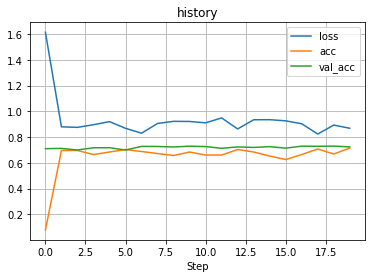

In [17]:
import matplotlib.pyplot as plt

plt.title('history')
plt.grid(True)
plt.xlabel('Step')
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='acc')
plt.plot(val_acc_history, label='val_acc')
plt.legend();

In [21]:
model

BertNet(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   